In [45]:
package 'Variation Definitions' {
	import ScalarValues::Real;
	import SI::mm;
	
	attribute def Diameter :> Real;
	
    part def Cylinder {
        attribute diameter : Diameter[1];
    }

    part def Engine {
    	part cylinder : Cylinder[2..*];
    }
    
    part '4cylEngine' : Engine {
    	part redefines cylinder[4];
    }
    
    part '6cylEngine' : Engine {
    	part redefines cylinder[6];
    }
    
    // Variability model
	
	variation attribute def DiameterChoices :> Diameter {
		variant attribute diameterSmall = 70[mm];
		variant attribute diameterLarge = 100[mm];
	}

	variation part def EngineChoices :> Engine {
		variant '4cylEngine';
		variant '6cylEngine';		
	}	

}

Package Variation Definitions (238db962-9ba1-44ac-8550-3ee204fce810)


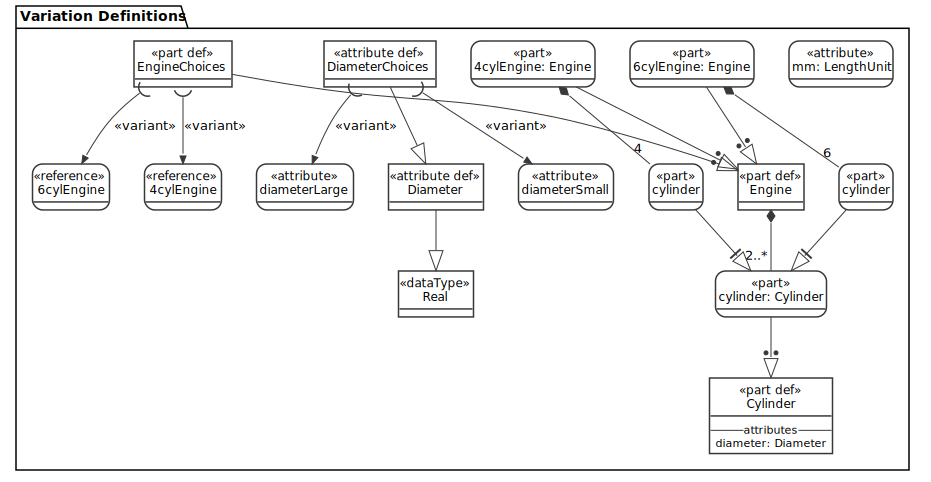

In [46]:
%viz "Variation Definitions"

In [107]:
package VariantModel {
    import ScalarValues::Real;
    import ScalarValues::Integer;

    attribute def Speed :> Real;
    attribute def PayloadCapacity :> Real;
    attribute def Cost :> Real;
    attribute def DroneType :> Integer;

    part def Drone{
        attribute speed : Speed;
        attribute payloadCapacity : PayloadCapacity;
        attribute cost : Cost;
        attribute droneType : DroneType;
    }

    package DroneSystem {
        part drone : Drone [4..*];
    }
    
}

Package VariantModel (097b0584-b414-44de-b103-836e27675a4f)


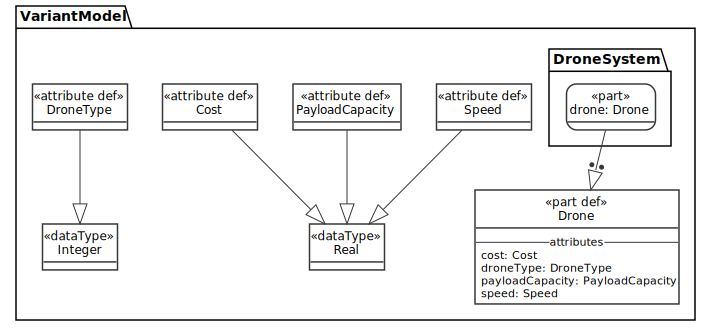

In [108]:
%viz VariantModel

In [49]:
package VehicleVariabilityModel {

	package DesignModel {
		import PartDefinitions::*;
		import PartsTree::*;
		import ActionDefinitions::*;
		import ActionTree::*;
	
		package PartDefinitions {
			part def Vehicle;
			
		    attribute def Diameter;
		    part def Cylinder {
		        attribute diameter : Diameter[1];
		    }
		
		    part def Engine;
		    part def Transmission;
		    part def Sunroof;
		
		    port def AutoPort;
	    }
	    
	    package PartsTree {
	    	part vehicle : Vehicle {
	    		part engine : Engine[1];
	    		part transmission : Transmission[1];
	    		part sunroof : Sunroof[0..1];
	    	}
	    	
		    part engine : Engine {
		        port autoPort : AutoPort;
		        part cylinder : Cylinder[2..*];
		    }
		    
		    part '4cylEngine' :> engine {
		    	part :>> cylinder[4];
		    }
		    
		    part '6cylEngine' :> engine {
		    	part :>> cylinder[6];
		    }
		
			part transmission : Transmission;
		    part manualTransmission :> transmission;
		    part automaticTransmission :> transmission;
	    }
	
		package ActionDefinitions {   
		    action def GenerateTorque;
		    action def AmplifyTorque;
		    action def ProvidePower;
	    }
	    
	    package ActionTree {    
		    action generateTorque4Cyl : GenerateTorque;
		    action generateTorque6Cyl : GenerateTorque;
		    
		    action amplifyTorqueManual : AmplifyTorque;
		    action amplifyTorqueAutomatic : AmplifyTorque;
	    }	
	}
		
	package '150% Model' {
		import DesignModel::*;
	
		package PartsTree {
		
		    // Variation point definitions
		
		    variation attribute def DiameterChoices :> Diameter {
		    	variant attribute diameterSmall;
		    	variant attribute diameterLarge;
		    }
		
		    variation part def EngineChoices :> Engine {
		        variant '4cylEngine';
		        variant '6cylEngine' {
		        	variation port :>> autoPort {
		        		variant port autoPort1;
		        		variant port autoPort2;
		        	}
		        	
		        	part :>> cylinder {
		        		attribute :>> diameter : DiameterChoices;
		        	}
		        	
		          	assert constraint {
		            	(autoPort == autoPort::autoPort1 & cylinder::diameter == cylinder::diameter::diameterSmall) ^
		             	(autoPort == autoPort::autoPort2 & cylinder::diameter == cylinder::diameter::diameterLarge)
		        	}
		        }
		    }
		
		    // Part superset model
		    
		    abstract part vehicleFamily :> vehicle {
		    	// Variation point usage
		        part :>> engine : EngineChoices[1];
		        
		        // Variation point with embedded variant definitions
		        variation part :>> transmission : Transmission[1] {
		        	variant manualTransmission;
		        	variant automaticTransmission;
		        }
		        
		        assert constraint {
		            (engine == '4cylEngine' & transmission == transmission::manualTransmission) ^
		            (engine == '6cylEngine' & transmission == transmission::automaticTransmission)
		        }
		        
		        // Variation point on variant multiplicity (inherited multiplicity is [0..1]) 
		        variation part :>> sunroof {
		        	variant part withSunroof[1];
		        	variant part withoutSunroof[0];
		        }
		        
		        perform ActionTree::providePowerFamily;
		    }
		}
		
		package ActionTree {
		
		    // Action superset Model
		    
		    action providePowerFamily : ProvidePower {
		        variation action generateTorque : GenerateTorque {
		        	variant generateTorque4Cyl;
		        	variant generateTorque6Cyl;
		        }
		        
		        variation action amplifyTorque : AmplifyTorque {
		        	variant amplifyTorqueManual;
		        	variant amplifyTorqueAutomatic;
		        }
		        
			    assert constraint {
			        (generateTorque == generateTorque::generateTorque4Cyl & 
			        	amplifyTorque == amplifyTorque::amplifyTorqueManual
			        ) ^
			        (generateTorque == generateTorque::generateTorque6Cyl & 
			        	amplifyTorque == amplifyTorque::amplifyTorqueAutomatic
			        )
			    }		   
		    }		    
		}
	}
	
	package '100% Model' {
		import '150% Model'::*;
		
		// Vehicle instance model
		
	    part vehicle4Cyl :> PartsTree::vehicleFamily {
	        part :>> engine = engine::'4cylEngine';
	        part :>> transmission = transmission::manualTransmission;
	        part :>> sunroof = sunroof::withoutSunroof;
	        
	        perform action :>> providePowerFamily {
	            action :>> generateTorque = generateTorque::generateTorque4Cyl;
	            action :>> amplifyTorque = amplifyTorque::amplifyTorqueManual;
	        }
	    }
	}
}

Package VehicleVariabilityModel (7ea6d434-1c73-4358-9a3f-71ba9fae9d40)


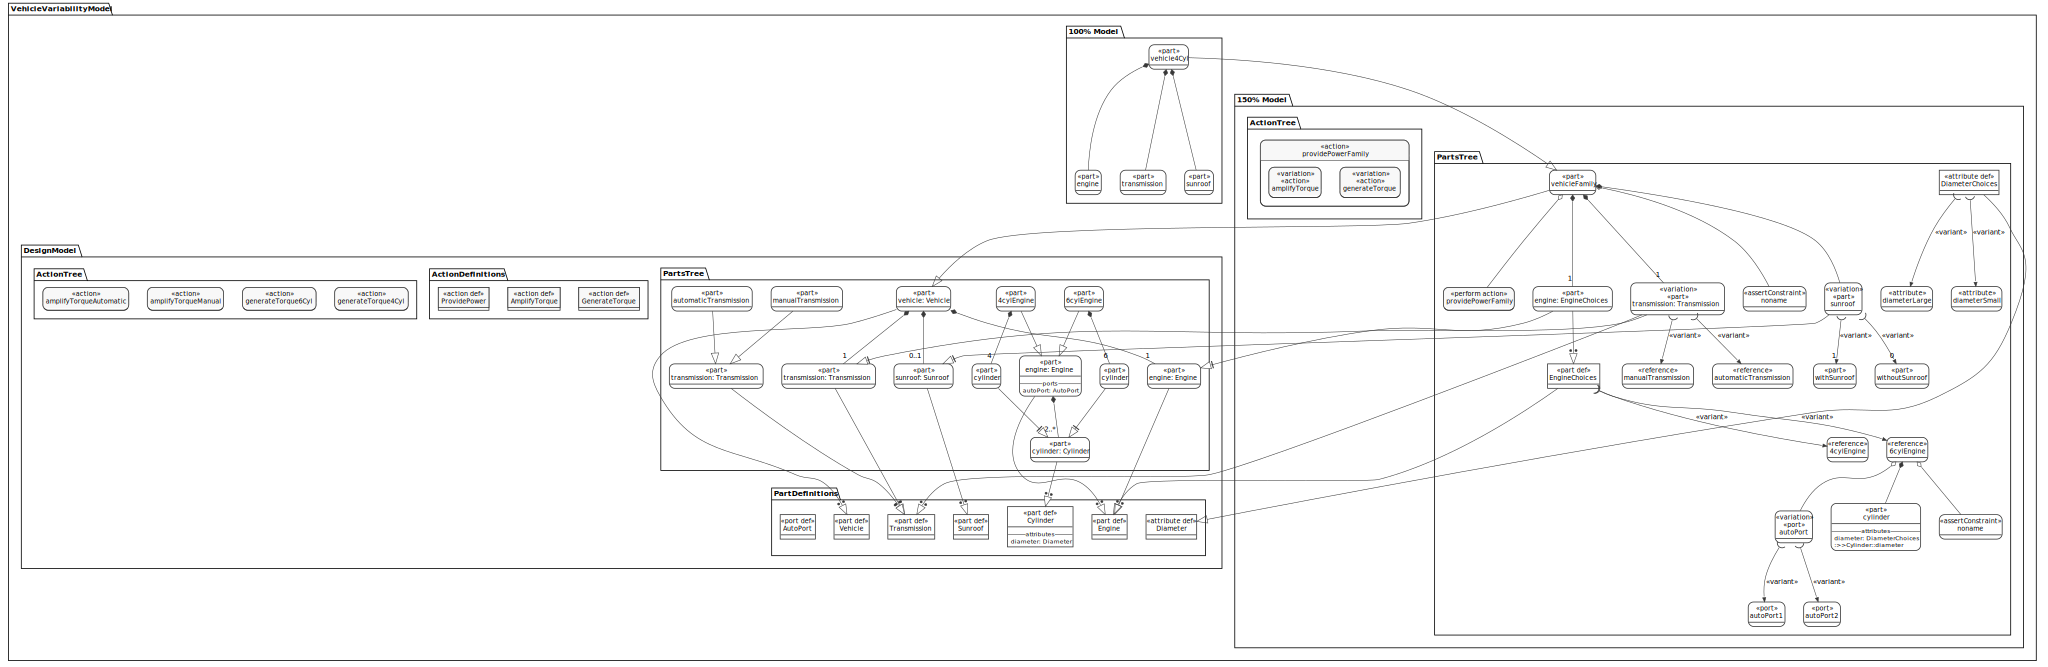

In [17]:
%viz VehicleVariabilityModel 